    Inés Fuai Guillén Peña      100495752

    Salvador Ayala Iglesias     100495832

En este **notebook** aplicaremos técnicas de agrupamiento (*clustering*) sobre un conjunto de datos. El objetivo principal es comprobar si existen agrupaciones naturales dentro del conjunto de datos, es decir, si es posible identificar grupos diferenciados sin conocer de antemano la clase real a la que pertenece cada muestra.

Para ello, probaremos distintos algoritmos de clustering y evaluaremos cuáles se ajustan mejor a la estructura de los datos. También exploraremos el efecto que tiene la normalización de las variables (escalado) en el rendimiento de estos métodos, así como la utilidad de reducir la dimensionalidad mediante técnicas como **PCA** (Análisis de Componentes Principales) para visualizar mejor los resultados.

La aplicación de la IA ha sido especialmente útil para resolver ciertos problemas surgidos durante el análisis. Además, nos ha permitido generar visualizaciones claras y significativas que ayudan a interpretar mejor los resultados obtenidos.

En primer lugar, declaramos todas las librerías necesarias para llevar a cabo la carga, el procesamiento y el análisis del conjunto de datos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# Scaler más apropiado con PCA

En primer lugar, cargamos el conjunto de datos desde el archivo *semillas.csv* utilizando la función *read_csv()* de la biblioteca *pandas*. Esto nos permite obtener un DataFrame con todas las observaciones y variables disponibles. Una vez cargados los datos, separamos las variables independientes de la variable dependiente (clase) y mostramos información general del dataset para verificar que no existen valores nulos ni inconsistencias en los tipos de datos.

Con el objetivo de analizar cómo afectan los diferentes métodos de escalado a la representación de los datos, definimos un diccionario con tres técnicas de normalización: **MinMaxScaler**, **StandardScaler** y **RobustScaler**. Para ello, construimos pipelines que combinan cada técnica de escalado con una reducción de dimensionalidad mediante **PCA (Análisis de Componentes Principales)**. Para cada técnica, representamos gráficamente la proyección de los datos sobre las dos primeras componentes principales, coloreando los puntos según su clase original. En los ejes de cada subgráfico indicamos el porcentaje de varianza explicada por cada componente, lo cual nos permite evaluar cuánta información de los datos originales se conserva tras la reducción.

Además, aplicamos **PCA** sin limitar el número de componentes para analizar la varianza explicada de forma más completa. En este caso, generamos un gráfico de barras para cada técnica de escalado con dos elementos clave:

- *Varianza explicada individual*, que muestra la proporción de varianza capturada por cada componente de forma independiente.

- *Varianza acumulada*, que indica cuánto se acumula al considerar sucesivas componentes principales.

Ambos elementos se representan de forma visual clara mediante un histograma de barras y una línea escalonada superpuesta.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        210 non-null    float64
 1   perimetro   210 non-null    float64
 2   compacidad  210 non-null    float64
 3   longitud    210 non-null    float64
 4   anchura     210 non-null    float64
 5   asimetria   210 non-null    float64
 6   surco       210 non-null    float64
 7   clase       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB
None
    area  perimetro  compacidad  longitud  anchura  asimetria  surco  clase
0  15.26      14.84      0.8710     5.763    3.312      2.221  5.220      1
1  14.88      14.57      0.8811     5.554    3.333      1.018  4.956      1
2  14.29      14.09      0.9050     5.291    3.337      2.699  4.825      1
3  13.84      13.94      0.8955     5.324    3.379      2.259  4.805      1
4  16.14      14.99      0.9034     5.658    3.562

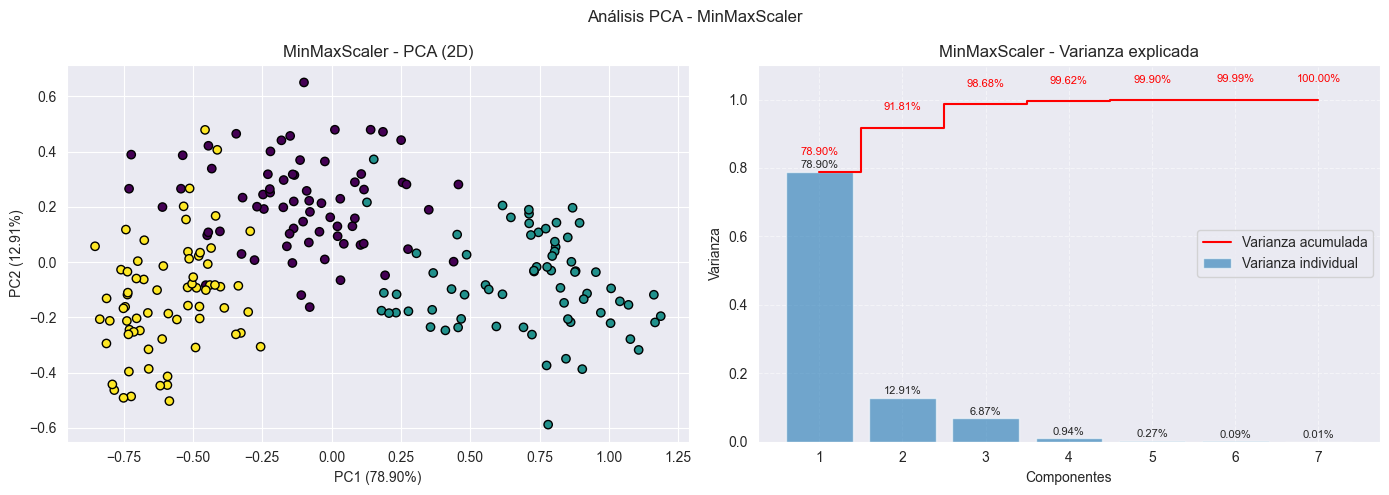

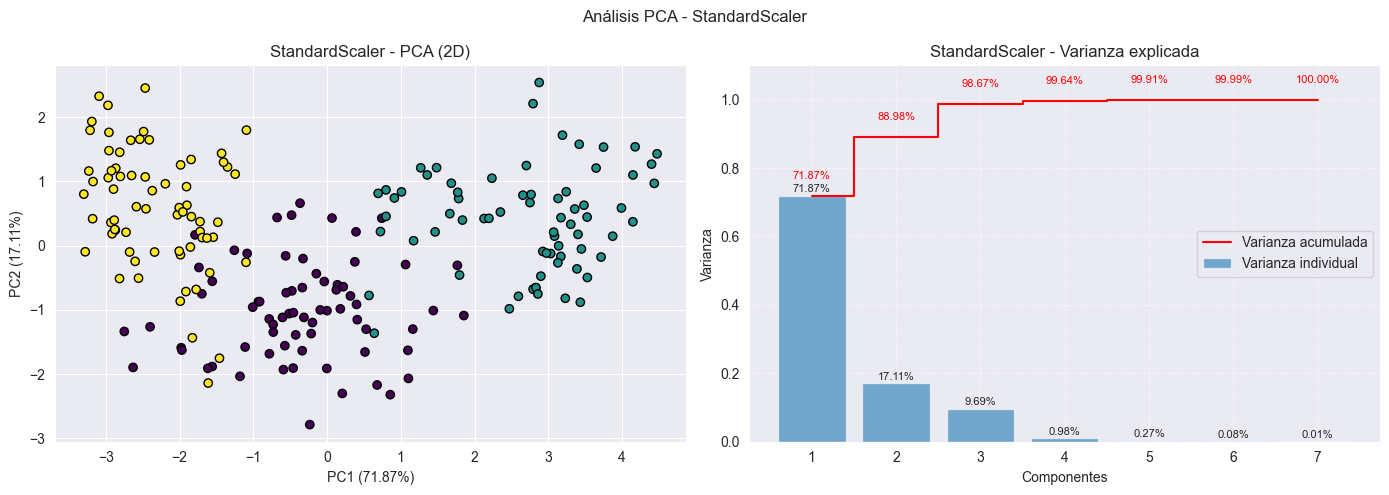

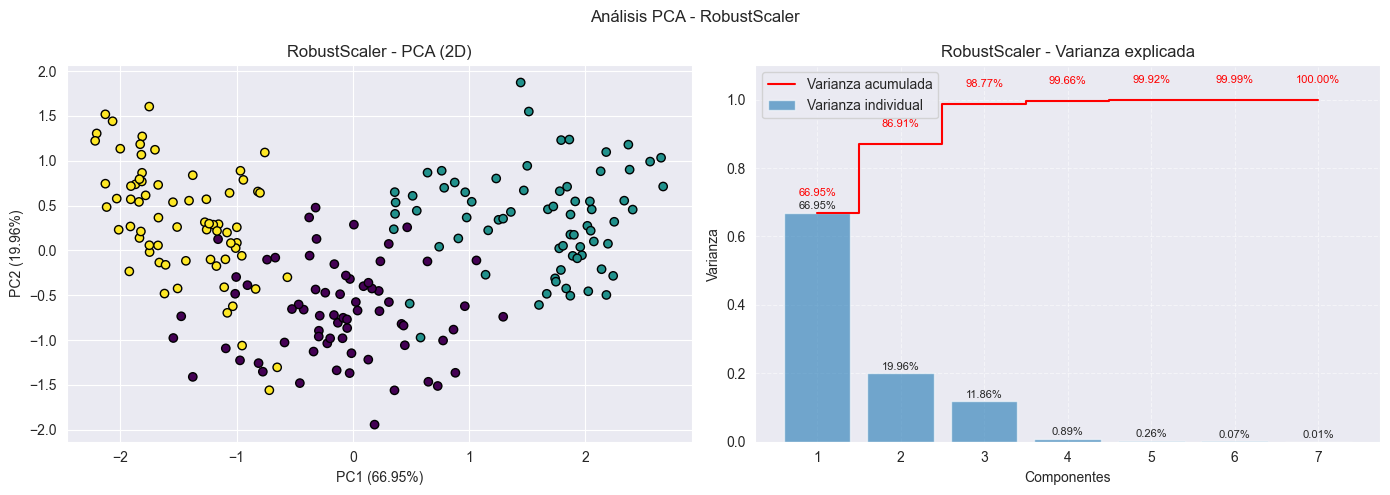

In [2]:
# cargamos el dataset
file_path = "semillas.csv"
df = pd.read_csv(file_path)

# mostramos información general del dataset
print(df.info())
print(df.head())

# separamos las variables independientes (X) y la variable dependiente (y)
X = df.drop("clase", axis=1)
y = df["clase"]

# diccionario con distintos métodos de escalado
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

for name, scaler in scalers.items():
    pipeline_2D = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_pca_2D = pipeline_2D.fit_transform(X)
    pca_2D = pipeline_2D.named_steps["pca"]
    explained_variance_2D = pca_2D.explained_variance_ratio_

    # PCA completo para varianza acumulada
    pipeline_full = Pipeline([
        ("scaler", scaler),
        ("pca", PCA())
    ])
    X_pca_full = pipeline_full.fit_transform(X)
    pca_full = pipeline_full.named_steps["pca"]
    explained_variance_full = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_full)

    # creamos figura con 2 subgráficos por scaler
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # subgráfico PCA 2D
    axs[0].scatter(X_pca_2D[:, 0], X_pca_2D[:, 1], c=y, cmap='viridis', edgecolor='k')
    axs[0].set_title(f"{name} - PCA (2D)")
    axs[0].set_xlabel(f"PC1 ({explained_variance_2D[0]:.2%})")
    axs[0].set_ylabel(f"PC2 ({explained_variance_2D[1]:.2%})")

    # subgráfico varianza explicada
    axs[1].bar(range(1, len(explained_variance_full)+1), explained_variance_full, alpha=0.6, label='Varianza individual')
    axs[1].step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')
    for i, (ev, cv) in enumerate(zip(explained_variance_full, cumulative_variance)):
        axs[1].text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center', fontsize=8)
        axs[1].text(i + 1, cv + 0.05, f"{cv:.2%}", ha='center', color='red', fontsize=8)
    axs[1].set_title(f"{name} - Varianza explicada")
    axs[1].set_xlabel("Componentes")
    axs[1].set_ylabel("Varianza")
    axs[1].legend()
    axs[1].set_ylim(0, 1.1)
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.suptitle(f"Análisis PCA - {name}")
    plt.tight_layout()
    plt.show()

Estas gráficas muestran la proporción de varianza explicada por cada componente principal después de aplicar **PCA** a los datos, con los datos escalados usando **MinMaxScaler**, **StandardScaler** y **RobustScaler** respectivamente. Las barras representan la varianza individual explicada por cada componente principal y la línea muestra la varianza acumulada explicada a medida que incluimos más componentes.

Ahora, analizaremos cada gráfica:
- **MinMaxScaler**: El primer componente principal (CP1) explica aproximadamente el *78.90%* de la varianza total. Para explicar casi toda la varianza (99.99%), necesitariamos **6 componentes** principales.  
 En la visualización de los datos proyectados en los dos primeros componentes principales, observamos que los clusters parecen estar relativamente cerca unos de otros y existe cierta superposición, especialmente entre el amarillo y el morado, en un espacio comprimido.

- **StandardScaler**: El primer componente principal (CP1) explica aproximadamente el *71.87%* de la varianza total. Similar a **MinMaxScaler**, para explicar casi toda la varianza (99.99%), necesitaríamos **6 componentes** principales. 
 La proyección de los datos en los dos primeros componentes principales muestra una mayor dispersión en comparación con **MinMaxScaler** y los clusters parecen estar un poco más separados, con una ligera reducción en la superposición entre el amarillo y el morado.

- **RobustScaler**: El primer componente principal (CP1) explica aproximadamente el *66.95%* de la varianza total. De nuevo, para explicar casi toda la varianza (99.99%), necesitaríamos **6 componentes** principales. La visualización de los datos en los dos primeros componentes principales presenta una dispersión similar a la de **StandardScaler**, con una separación visual de los clusters también comparable y una superposición entre el amarillo y el morado similar o ligeramente menor que con **MinMaxScaler**.

Observando la varianza acumulada explicada, los tres escaladores resultan en porcentajes muy similares de varianza explicada para un número dado de componentes principales:

- Para capturar alrededor del 90% de la varianza, necesitaríamos 2 componentes principales independientemente del escalador utilizado.

- Para capturar alrededor del 98-99% de la varianza, necesitaríamos 3 componentes principales en todos los escaladores.

- Para capturar casi toda la varianza (99.99%), necesitamos 6 componentes principales en todos los casos.

Por lo tanto, basándonos únicamente en la cantidad de varianza explicada por los componentes principales, no hay una diferencia significativa entre usar **MinMaxScaler**, **StandardScaler** o **RobustScaler**. Sin embargo, al observar la proyección de los datos en los dos primeros componentes principales y la separación visual de los clusters identificados, tanto **StandardScaler** como **RobustScaler** parecen ofrecer una ligera ventaja sobre **MinMaxScaler** al mostrar una mayor dispersión de los datos y una menor superposición entre los clusters, esto sugiere que podrían ser más adecuados para facilitar la tarea del algoritmo de clustering posterior en este conjunto de datos.

En nuestro caso, hemos elegido **RobustScaler**.

# Técnicas de clustering

En este siguiente apartado, analizamos los datos previamente transformados a un espacio bidimensional mediante **RobustScaler** con **PCA (Análisis de Componentes Principales)**, con el objetivo de aplicar y comparar tres técnicas de clustering no supervisado: **K-Means**, **Clustering Jerárquico (Aglomerativo)** y **DBSCAN**. Estas técnicas permiten agrupar instancias sin utilizar la variable objetivo, lo cual es esencial en contextos donde no se dispone de etiquetas previas. El análisis de agrupaciones sin supervisión también puede ser útil para explorar la estructura interna de los datos y revelar patrones o grupos que no son inmediatamente evidentes.

Cada uno de estos métodos tiene sus propias características y criterios para definir los clusters y en este apartado detallamos las decisiones tomadas para cada caso.

In [3]:
# transformamos los datos: RobustScaler + PCA
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=2))
])
X_2D = pipeline.fit_transform(X)

**K-Means**

El primer paso para aplicar el algoritmo **K-Means** es determinar el número óptimo de clusters. Para ello, utilizamos dos enfoques:
    
- Primero, empleamos el **método del codo**, que consiste en observar cómo varía la inercia (dispersión dentro de los clusters) en función del número de clusters. El punto donde la disminución de la inercia empieza a estabilizarse es el que sugiere el número adecuado de agrupaciones. 

- En segundo lugar, evaluamos el **coeficiente de silueta**, que mide la cohesión dentro de los clusters y la separación entre ellos. Un valor cercano a 1 indica una buena separación. 
    
Ambas métricas se visualizan mediante gráficos, lo que nos facilita la elección del valor óptimo de *k*.

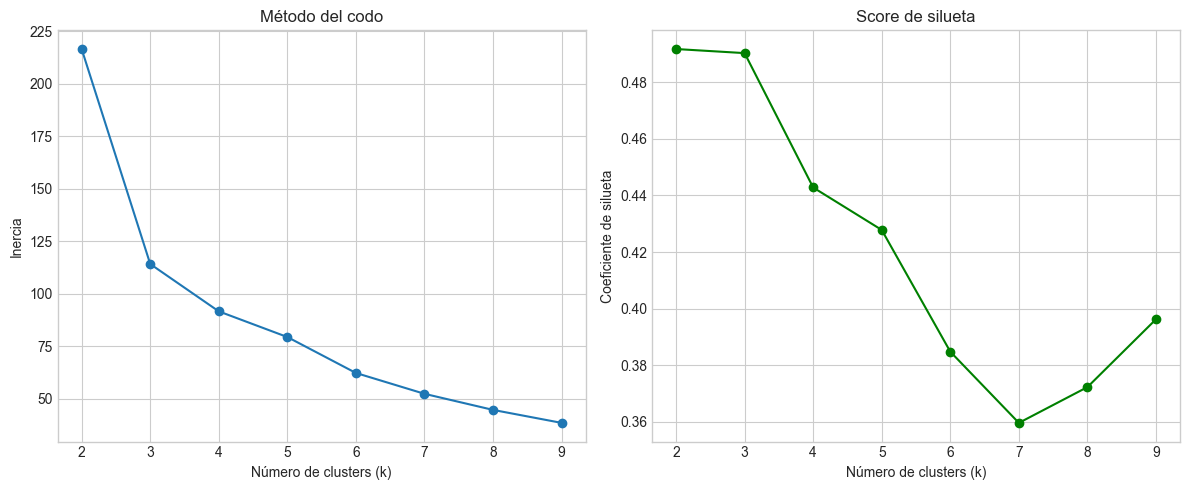

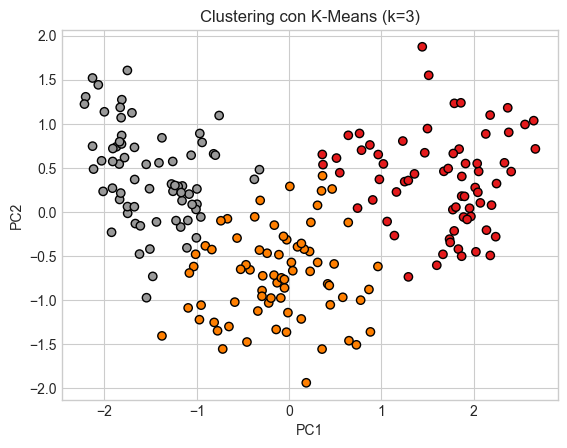

In [4]:
# --------------------------
# K-MEANS
# --------------------------
inertias = [] 
siluetas = [] 

for k in range(2, 10): # iteramos entre 2 y 9 para saber el mejor número de clusters
    km = KMeans(n_clusters=k, random_state=495752)
    labels = km.fit_predict(X_2D)
    inertias.append(km.inertia_) # dispersión dentro de cada cluster
    siluetas.append(silhouette_score(X_2D, labels)) # valores cercanos a 1 indican una buena separación (cada punto respecto a otros clusters)

# gráfico del metodo del codo y silueta
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertias, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")

plt.subplot(1, 2, 2)
plt.plot(range(2, 10), siluetas, marker='o', color='green')
plt.title("Score de silueta")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente de silueta")

plt.tight_layout()
plt.show()

# aplicamos KMeans con k=3 (según codo y silueta)
kmeans = KMeans(n_clusters=3, random_state=495752)
kmeans_labels = kmeans.fit_predict(X_2D)

plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=kmeans_labels, cmap='Set1', edgecolor='k')
plt.title("Clustering con K-Means (k=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

 Como podemos observar, **K-menas** resultó ser eficaz para detectar clusters compactos y bien separados. Seleccionamos *k=3* basándonos en el resultado que obtuvimos en el *método del codo*, que mostró un punto de inflexión claro en la curva de inercia. Además, el *coeficiente de silueta* alcanzó valores altos para *k=3*, lo que confirmó que esta selección era la más adecuada.


**Clustering Jerárquico (Aglomerativo)**

Este método construye una jerarquía de grupos que se pueden representar visualmente en un **dendrograma**, que es un gráfico de árbol donde se muestran las fusiones entre los puntos en función de la distancia. El dendrograma nos permite explorar varias alturas de corte, lo que equivale a examinar distintas soluciones de agrupación. Además, para determinar el número óptimo de clusters, analizamos los **saltos en las alturas de fusión**, donde el mayor salto indica el punto más apropiado para cortar el dendrograma. En este análisis, exploramos tres métodos de enlace: **Ward**, **Complete** y **Average**, cada uno con características propias que afectan la manera en que se agrupan las instancias.


--- Método: ward ---
Número óptimo de clusters: 2
Altura de fusión óptima: 14.84


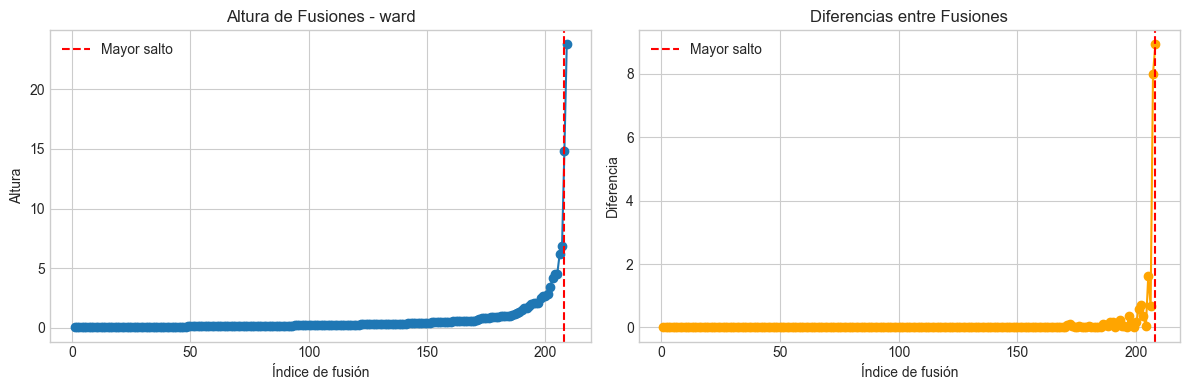

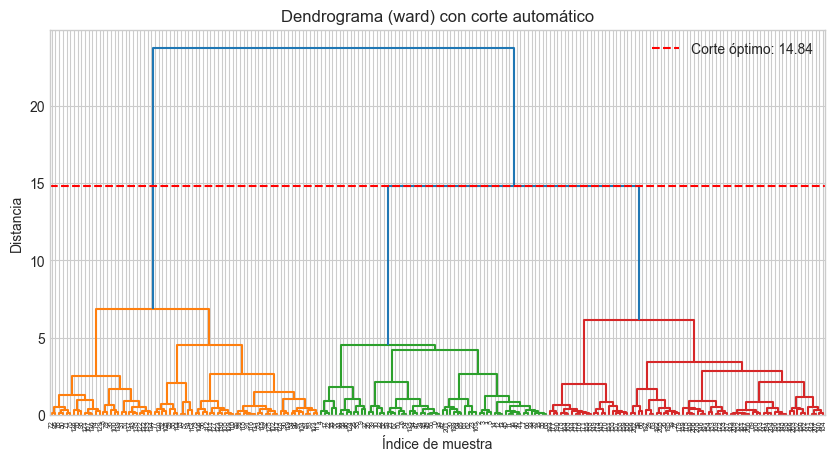


--- Método: complete ---
Número óptimo de clusters: 3
Altura de fusión óptima: 3.25


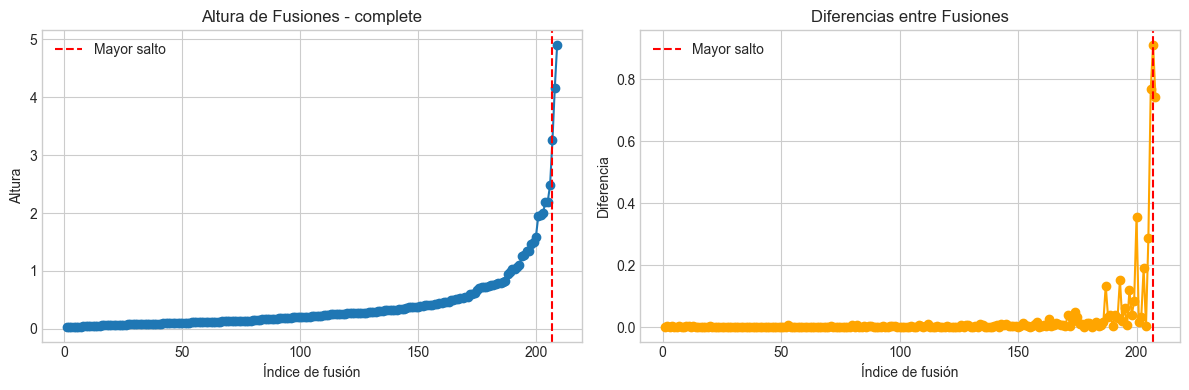

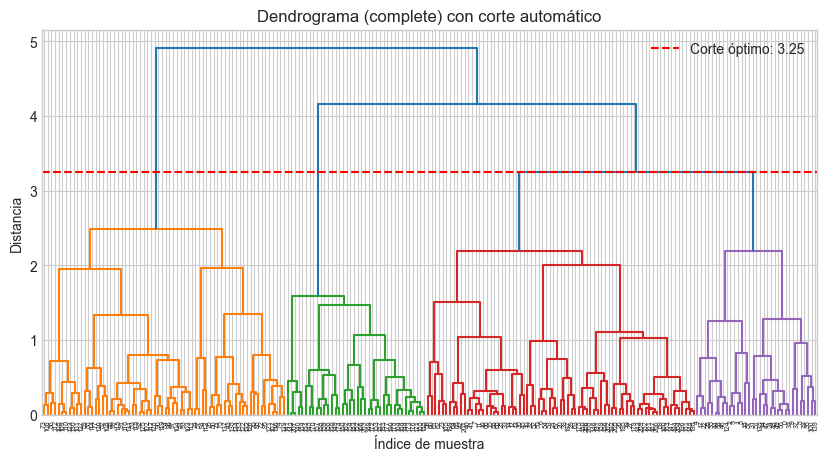


--- Método: average ---
Número óptimo de clusters: 2
Altura de fusión óptima: 1.92


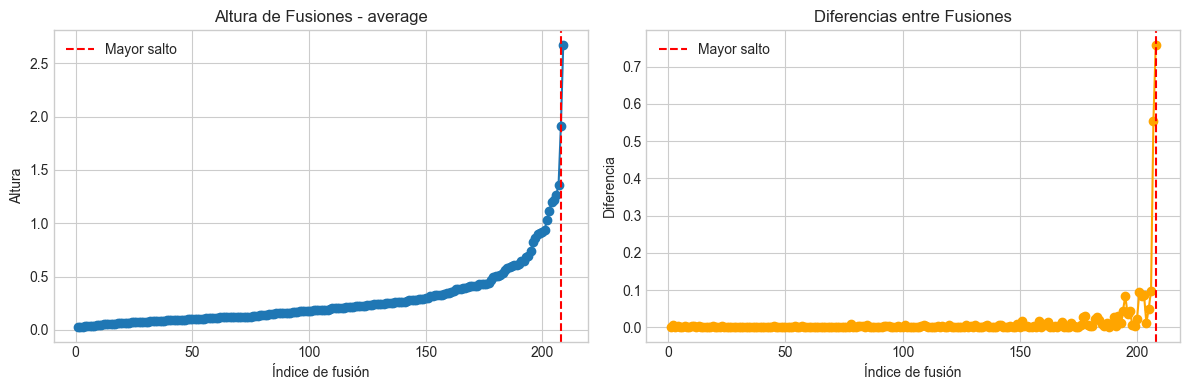

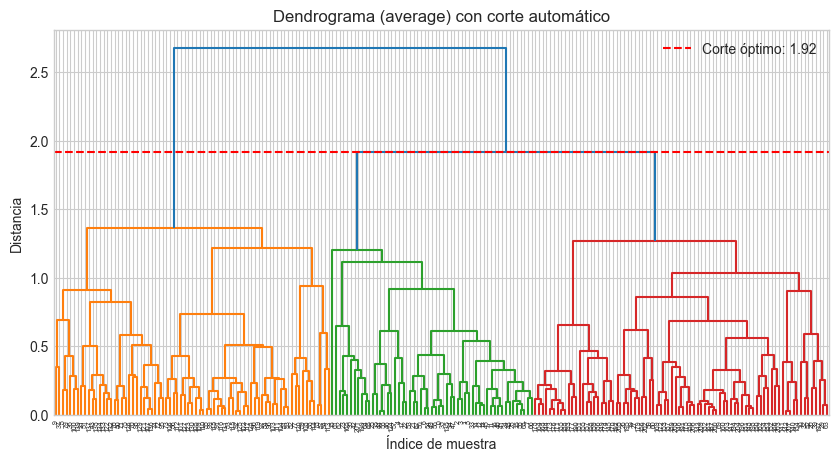

--- WARD ---
Número de clusters: 2
Silhouette Score: 0.4861
Calinski-Harabasz Index: 255.39



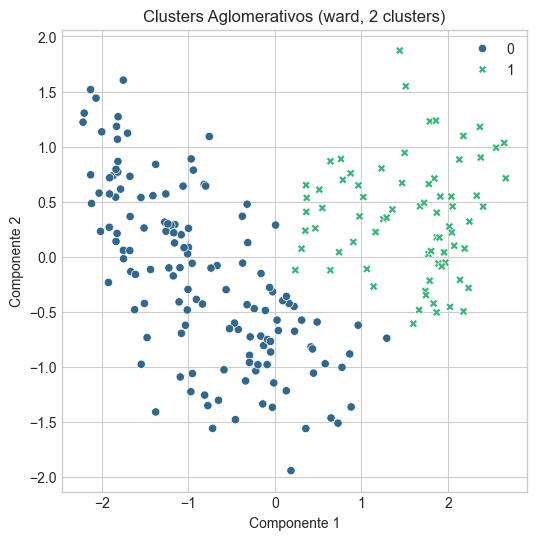

--- COMPLETE ---
Número de clusters: 3
Silhouette Score: 0.4038
Calinski-Harabasz Index: 259.16



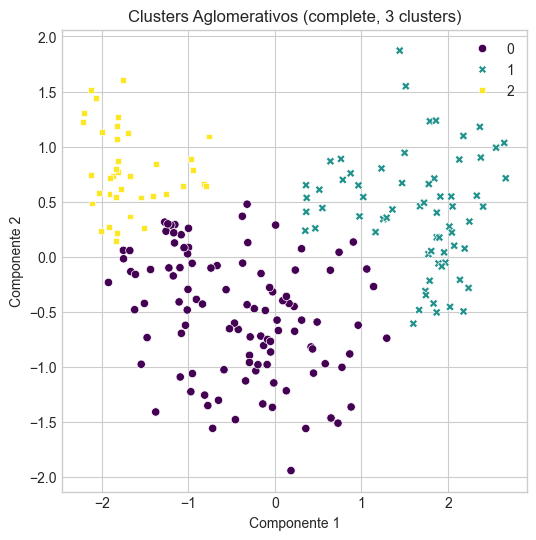

--- AVERAGE ---
Número de clusters: 2
Silhouette Score: 0.4933
Calinski-Harabasz Index: 267.32



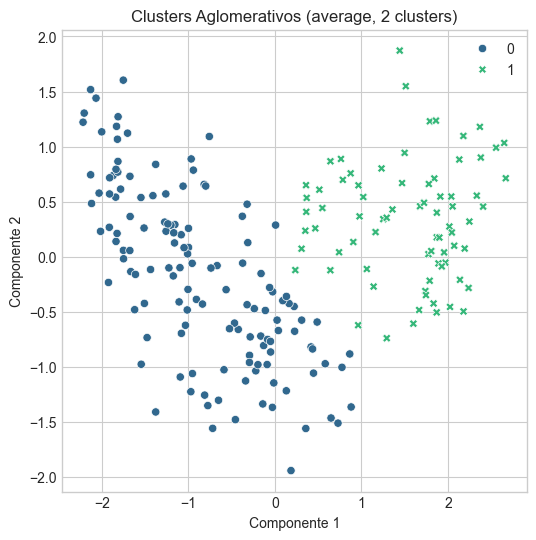

In [5]:
# --------------------------
# Hierarchical Clustering / Dendrogramas
# --------------------------
linkages = ["ward", "complete", "average"]

for method in linkages:
    print(f"\n--- Método: {method} ---")

    # calculamos la matriz de enlace
    Z = linkage(X_2D, method=method)

    heights = Z[:, 2] # alturas de fusión
    diffs = np.diff(heights) # diferencias entre alturas consecutivas

    # indice del mayor salto
    idx_max_jump = np.argmax(diffs)
    altura_optima = heights[idx_max_jump]
    n_clusters_optimo = len(heights) - idx_max_jump

    print(f"Número óptimo de clusters: {n_clusters_optimo}")
    print(f"Altura de fusión óptima: {altura_optima:.2f}")

    # gráfica de las alturas y de los saltos
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # alturas de fusión
    ax[0].plot(range(1, len(heights) + 1), heights, marker='o')
    ax[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
    ax[0].set_title(f"Altura de Fusiones - {method}")
    ax[0].set_xlabel("Índice de fusión")
    ax[0].set_ylabel("Altura")
    ax[0].legend()

    # saltos entre fusiones
    ax[1].plot(range(1, len(diffs) + 1), diffs, marker='o', color='orange')
    ax[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
    ax[1].set_title("Diferencias entre Fusiones")
    ax[1].set_xlabel("Índice de fusión")
    ax[1].set_ylabel("Diferencia")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # dendrograma con línea de corte
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 5))
    dendrogram(Z, color_threshold=altura_optima)
    plt.axhline(y=altura_optima, color='r', linestyle='--', label=f'Corte óptimo: {altura_optima:.2f}')
    plt.title(f"Dendrograma ({method}) con corte automático")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Distancia")
    plt.legend()
    plt.show()


# usamos ahora aglomerative, silueta y calinski para comprobar los resultados anteriormente obtenidos 
resultados_agglomerative = {
    "ward": 2,
    "complete": 3,
    "average": 2
}

for metodo, n_clusters in resultados_agglomerative.items():
    modelo = AgglomerativeClustering(n_clusters=n_clusters, linkage=metodo)
    etiquetas = modelo.fit_predict(X_2D)

    # cálculo de métricas
    silhouette = silhouette_score(X_2D, etiquetas)
    ch_index = calinski_harabasz_score(X_2D, etiquetas)

    print(f"--- {metodo.upper()} ---")
    print(f"Número de clusters: {n_clusters}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}\n")

    # visualización de los clusters
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=etiquetas, palette='viridis', style=etiquetas)
    plt.title(f"Clusters Aglomerativos ({metodo}, {n_clusters} clusters)")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.show()

Hemos realizado un análisis empleando tres métodos de enlace: **ward**, **complete** y **average**. Para cada uno, calculamos la altura óptima de corte mediante el mayor salto en las fusiones del dendrograma y evaluamos la calidad del agrupamiento con las métricas *Silhouette Score* y *Calinski-Harabasz Index*. 
    
- En el *dendrograma de Ward*, observamos una altura de fusión óptima de 14.84, lo que sugiere una separación clara entre los dos principales grupos antes de unirse. Con **2 clusters**, este método alcanza un *Silhouette Score de 0.4861* y un *Calinski-Harabasz Index de 255.39*. 
  
- En el *dendrograma de Complete*, el corte óptimo se encuentra en una altura de 3.25, lo que conduce a una segmentación en **3 clusters**. Sin embargo, su Silhouette Score es más bajo (0.4038), aunque el Calinski-Harabasz alcanza 259.16. 
  
- Por último, el *dendrograma de Average* muestra una altura de fusión óptima de 1.92, también con **2 clusters**, obteniendo el mejor Silhouette Score (0.4933) y el mayor Calinski-Harabasz Index (267.32) de los tres métodos. 
    
Las visualizaciones apoyan la idea de que **2 clusters** son la mejor forma de representar la estructura de los datos con el **Clustering Aglomerativo**. Tanto el método *ward* como el *average* muestran una separación bastante clara cuando se agrupa en 2. Además, el método *average* da resultados un poco mejores, por lo que podría ser la opción más recomendable. 
Por otro lado, aunque añadir un tercer clúster con el método *complete* mejora el índice de Calinski-Harabasz, parece empeorar la separación general según el Silhouette Score.

**DBSCAN**
 
A diferencia de **K-Means** y el **clustering jerárquico**, este  se basa en la densidad de los puntos para formar los clusters, lo que lo hace especialmente útil cuando los clusters tienen formas arbitrarias. El parámetro más importante en DBSCAN es *eps* (el radio máximo de los puntos vecinos) y *min_samples* (el número mínimo de puntos que se requieren para formar un cluster). En este análisis, seleccionamos el valor adecuado de *eps* mediante un gráfico de k-distancia, que nos permite observar la variación de la distancia a los *min_samples*-ésimos vecinos más cercanos. Posteriormente, probamos varias combinaciones de parámetros para encontrar la que maximice la calidad de la agrupación, evaluada mediante las métricas de **Silhouette Score** y **Calinski-Harabasz Score**.

Para realizar esta parte, aplicamos cada técnica de clustering y visualizamos los resultados para entender cómo se agrupan las instancias.

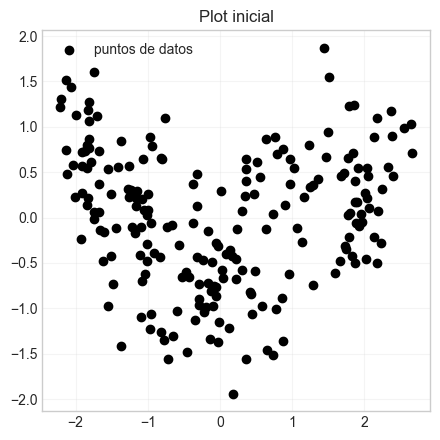

Numero de clusters iniciales: 9
Numero de outliers iniciales: 104


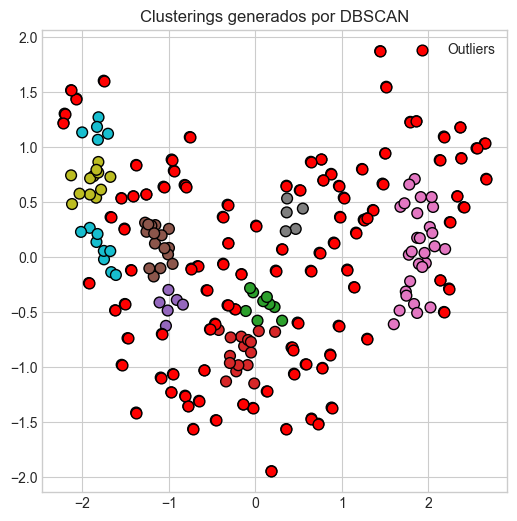

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x=X_2D[:, 0],
    y=X_2D[:, 1],
    c='black',
    marker='o',
    edgecolor='black',
    label='puntos de datos'
)
ax.legend()
ax.set_title('Plot inicial')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

modelo_dbscan = DBSCAN(
    eps=0.2,
    min_samples=5,
    metric='euclidean',
)
modelo_dbscan.fit(X=X_2D)

labels = modelo_dbscan.labels_
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

unique_labels = np.unique(labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
cmap_name = 'tab10'
cmap = plt.get_cmap(cmap_name)

scatter = ax.scatter(
    x=X_2D[:, 0],
    y=X_2D[:, 1],
    c=np.where(labels != -1, labels, -2),
    cmap=cmap,
    marker='o',
    edgecolor='black',
    s=60
)

# los outliers se identifican con el label -1
outliers = X_2D[labels == -1]
ax.scatter(
    outliers[:, 0],
    outliers[:, 1],
    c='red',
    marker='o',
    edgecolor='black',
    s=60,
    label='Outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

clusters_iniciales = len(set(labels)) - (1 if -1 in labels else 0)
ruido_inicial = list(labels).count(-1)

print(f"Numero de clusters iniciales: {clusters_iniciales}")
print(f"Numero de outliers iniciales: {ruido_inicial}")

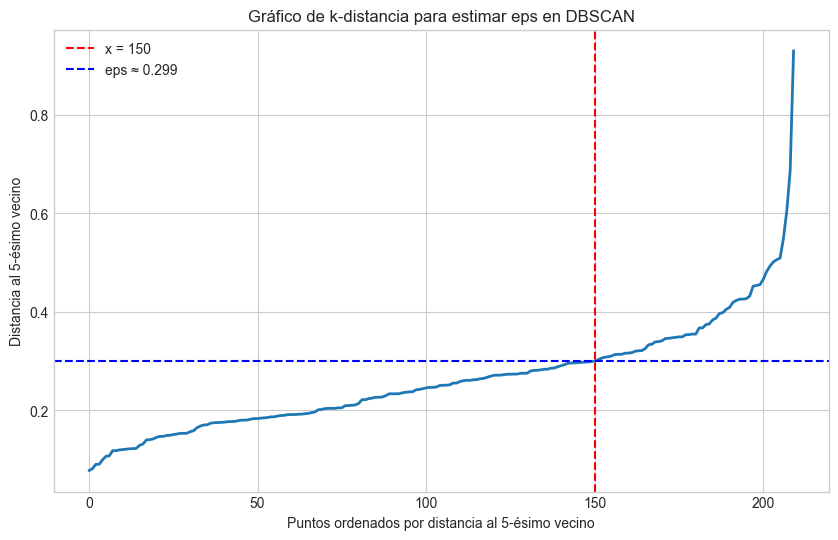

x_point = 150, eps sugerido = 0.299
    eps  min_samples  num_clusters  noise_points  silhouette_score  \
1   0.3            5             5            22          0.282844   
2   0.3            7             4            59          0.270779   
7   0.4           10             3            38          0.193595   
3   0.3           10             4           109          0.032097   
0   0.3            3             3            10         -0.042223   
4   0.4            3             1             4         -1.000000   
5   0.4            5             1             9         -1.000000   
6   0.4            7             1            13         -1.000000   
8   0.5            3             1             0         -1.000000   
9   0.5            5             1             1         -1.000000   
10  0.5            7             1             3         -1.000000   
11  0.5           10             1             5         -1.000000   
12  0.6            3             1             0      

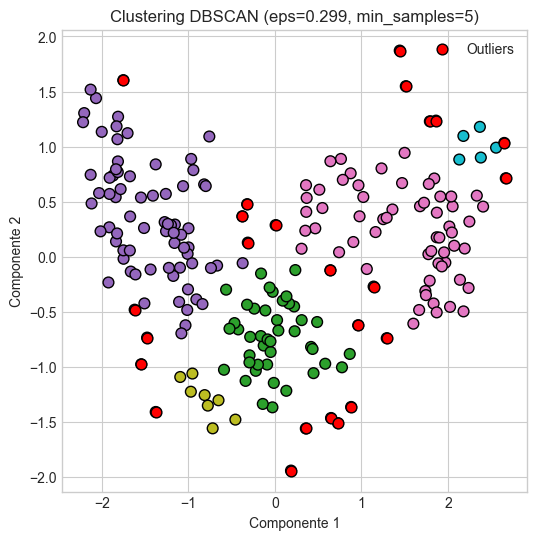


Número de clusters final (eps=0.299): 5
Número de outliers final (eps=0.299): 24


In [7]:
#
# - - - - AHORA SACAMOS LOS MEJORES EPS Y MIN_SAMPLES - - - - #
#

min_samples_k = 5

# calculamos las distancias de los vecinos
nn = NearestNeighbors(n_neighbors=min_samples_k)
nn.fit(X_2D)
distances, _ = nn.kneighbors(X_2D)

# ordenamos las distancias
sorted_distances = np.sort(distances[:, min_samples_k - 1])

# gráfico de k-distancia
x_point = 150 
y_value = sorted_distances[x_point]

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances, linewidth=2)
plt.xlabel(f'Puntos ordenados por distancia al {min_samples_k}-ésimo vecino')
plt.ylabel(f'Distancia al {min_samples_k}-ésimo vecino')
plt.title('Gráfico de k-distancia para estimar eps en DBSCAN')

plt.axvline(x=x_point, color='red', linestyle='--', label=f'x = {x_point}')
plt.axhline(y=y_value, color='blue', linestyle='--', label=f'eps ≈ {round(y_value, 3)}')

plt.legend()
plt.grid(True)
plt.show()

print(f"x_point = {x_point}, eps sugerido = {round(y_value, 3)}")

# ahora probamos varias combinaciones de eps y min_samples para averiguar cual es el mejor
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [3, 5, 7, 10]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_2D)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # nº de clusters, sin contar outliers (-1)
        noise_points = np.sum(labels == -1)  # puntos considerados outliers

        if num_clusters > 1:
            silhouette = silhouette_score(X_2D, labels)  # Silhouette Score
            ch_score = calinski_harabasz_score(X_2D, labels)  # Calinski-Harabasz Index
        else:
            silhouette = -1
            ch_score = -1

        # guardamos los resultados
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'num_clusters': num_clusters,
            'noise_points': noise_points,
            'silhouette_score': silhouette,
            'calinski_harabasz_score': ch_score
        })

# mostramos los resultados ordenados por Silhouette Score
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='silhouette_score', ascending=False))  # ordenamos por calidad (Silhouette Score)

# seleccionamos el mejor modelo DBSCAN
best_dbscan = DBSCAN(eps=0.299, min_samples=5)
labels = best_dbscan.fit_predict(X_2D)

fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='tab10', edgecolor='k', s=60)

# marcamos los outliers
outliers = X_2D[labels == -1]
ax.scatter(
    outliers[:, 0],
    outliers[:, 1],
    c='red',
    edgecolor='k',
    s=60,
    label='Outliers'
)
ax.set_title('Clustering DBSCAN (eps=0.299, min_samples=5)')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.legend()
ax.grid(True)

plt.show()

# imprimimos el número de clusters y outliers del mejor modelo
n_clusters_final = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers_final = list(labels).count(-1)

print(f"\nNúmero de clusters final (eps=0.299): {n_clusters_final}")
print(f"Número de outliers final (eps=0.299): {n_outliers_final}")

Finalmente, seleccionamos un valor de *eps=0.299* para el **modelo DBSCAN final**. Este valor se basó en la sugerencia obtenida del gráfico de k-distancia, que identificó un punto de inflexión potencial alrededor de esta distancia. 

Al utilizar este valor de eps en combinación con *min_samples=5*, el algoritmo logró identificar una estructura de clustering interpretable en los datos, con un número de clusters de 5 y 24 puntos considerados ruido. Aunque habiamos realizado una búsqueda de parámetros exploratoria obteniendo que *eps=0.3* podría ofrecernos métricas ligeramente superiores en algunos casos, priorizamos el valor sugerido por el análisis del k-vecino como un punto de partida más acorde con la forma en que se distribuyen las densidades dentro de los datos.

Comparando los resultados iniciales y finales del clustering, podemos confirmar que, inicialmente, identificamos 9 clusters y 104 outliers. Mientras que con los parámetros finales obtuvimos 5 clusters y 24 outliers. Esto indica que la configuración final llevó a la fusión de algunos de los clusters iniciales (o a que algunos de ellos se 'disolvieran') y que la configuración final fue más efectiva para agrupar los puntos que antes se consideraban ruido en los clusters.

En resumen, la configuración final de **DBSCAN** resultó en menos clusters pero también en una notable reducción de la cantidad de puntos clasificados como outliers, lo que implica una mejor cobertura de los datos por parte de los clusters identificados.

# Análisis

En esta última sección, vamos a evaluar el rendimiento de **tres técnicas de clustering no supervisado** aplicadas sobre el conjunto de datos de semillas.

El objetivo es identificar, a través de una comprobación visual, cuál de estos métodos es capaz de capturar de forma más precisa la estructura de los datos, es decir, qué técnica genera agrupaciones más coherentes y bien separadas.

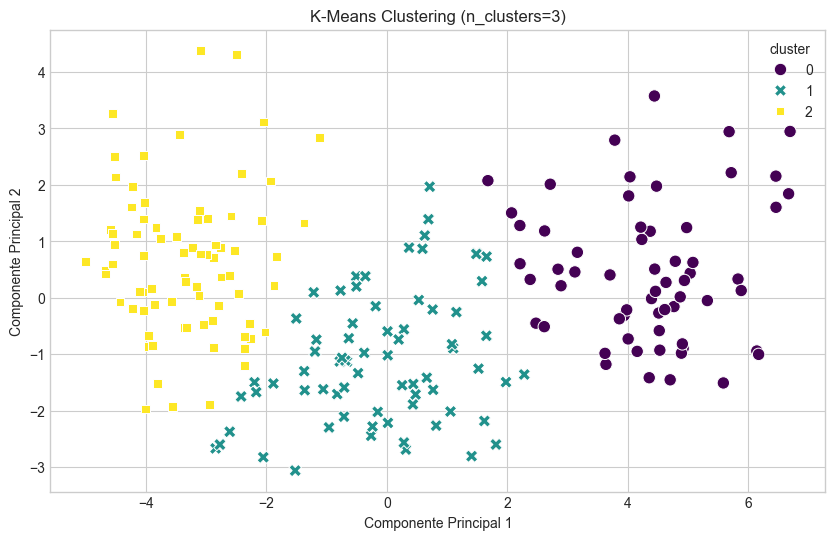

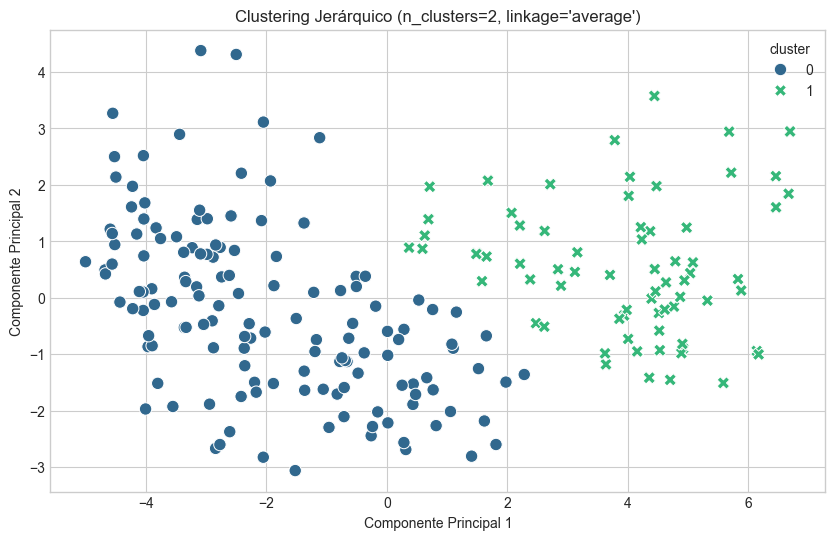

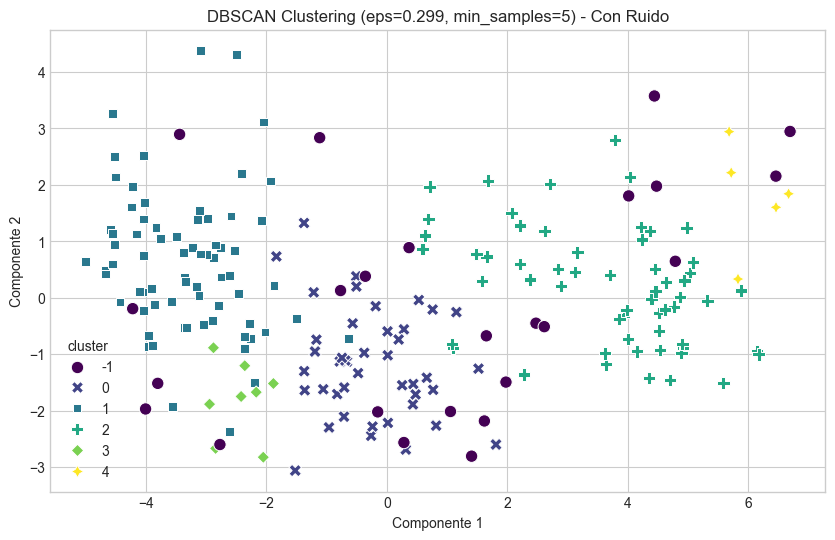

In [8]:
X = df.drop(columns='clase') # separamos las características de la variable objetivo
pca = PCA(n_components=2) # aplicamos PCA
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# creamos DataFrames para almacenar los resultados del clustering
df_clustered_kmeans = pca_df.copy()
df_clustered_hierarchical = pca_df.copy()
df_clustered_dbscan = pca_df.copy()

# ------------------ K-Means -------------------
n_clusters_kmeans = 3 
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=495752, n_init=10)
df_clustered_kmeans['cluster'] = kmeans.fit_predict(pca_df)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clustered_kmeans, x='PC1', y='PC2', hue='cluster', palette='viridis', style='cluster', s=80)
plt.title(f"K-Means Clustering (n_clusters={n_clusters_kmeans})")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# ------------------ Clustering Jerárquico -------------------
n_clusters_hierarchical = 2
hierarchical = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, linkage='average')
df_clustered_hierarchical['cluster'] = hierarchical.fit_predict(pca_df)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clustered_hierarchical, x='PC1', y='PC2', hue='cluster', palette='viridis', style='cluster', s=80)
plt.title(f"Clustering Jerárquico (n_clusters={n_clusters_hierarchical}, linkage='average')")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# ------------------ DBSCAN -------------------
eps_dbscan = 0.299 # Usando el mejor eps encontrado en el primer código
min_samples_dbscan = 5
dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
df_clustered_dbscan['cluster'] = dbscan.fit_predict(X_2D)

# visualizamos también el ruido
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clustered_dbscan, x='PC1', y='PC2', hue='cluster', palette='viridis', style='cluster', s=80)
plt.title(f"DBSCAN Clustering (eps={eps_dbscan}, min_samples={min_samples_dbscan}) - Con Ruido")
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

- **K-Means**: Con 3 clusters parece haber identificado tres grupos principales que se corresponden vagamente con las concentraciones de puntos en el gráfico de datos iniciales. El cluster 2 parece capturar bien el grupo de la izquierda, el cluster 1 se centra en la parte inferior central y el cluster 0 claro en la derecha.

- **Clustering Jerárquico**: Con 2 clusters divide los datos en dos grupos principales.  Un cluster abarca la mayor parte de los puntos de la izquierda y el centro, mientras que el otro se concentra más a la derecha.

- **DBSCAN**: Identifica varios clusters (0, 1, 2, 3, 4) y también puntos considerados ruido (-1). Observamos varios grupos más pequeños que parecen corresponder a áreas de mayor densidad en el gráfico inicial.

Considerando la dispersión de los puntos en el gráfico inicial, **K-Means**, con tres clusters, parece ofrecer una representación más equilibrada de las agrupaciones visuales que se pueden intuir. Intenta dividir los datos en tres partes que guardan cierta correspondencia con las áreas donde los puntos parecen más concentrados en el gráfico inicial. Si bien **DBSCAN** identifica núcleos densos, la cantidad de ruido sugiere que puntos que visualmente parecen formar parte de una estructura (aunque no densa) no son capturados como clusters. El **clustering jerárquico**, al usar solo dos clusters, no logra reflejar la aparente separación en más de dos grupos que se observa en el gráfico inicial.

En conclusión, **K-Means** parece capturar la estructura inicial de los datos de forma más precisa que el **clustering jerárquico** (que simplifica demasiado) y **DBSCAN** (que marca puntos como ruido). Logra una división en tres grupos que se alinea razonablemente bien con las concentraciones visuales en el gráfico inicial.

Además, analizaremos si existe relación entre los clusters generados por los algoritmos y las clases reales de semillas (variable de respuesta "clase"). Aunque los algoritmos de clustering no utilizan esta variable durante el proceso, comparar los resultados obtenidos con las etiquetas originales puede aportar una idea clara sobre la calidad de la segmentación.

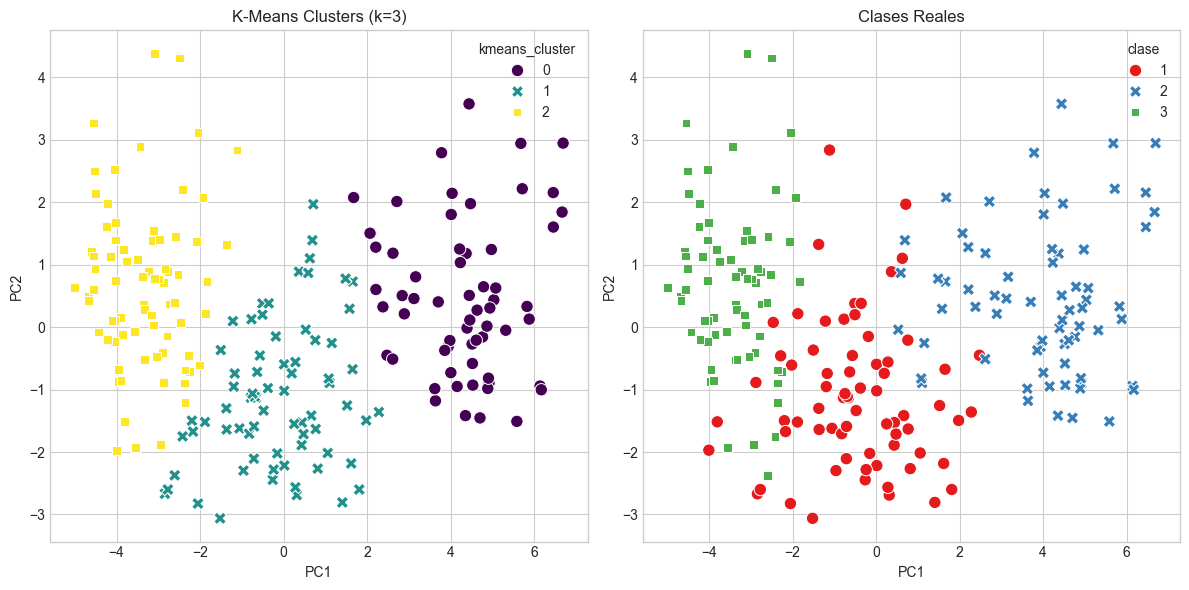


Tabla de Contingencia: K-Means vs. Clase
clase            1   2   3
kmeans_cluster            
0                1  60   0
1               60  10   2
2                9   0  68


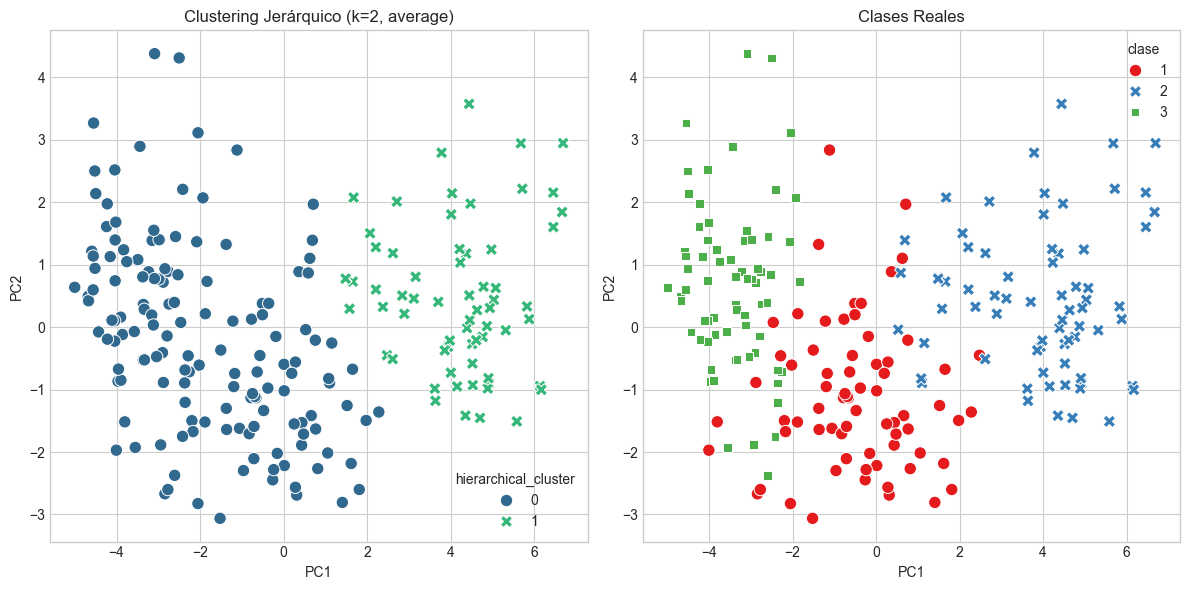


Tabla de Contingencia: Clustering Jerárquico vs. Clase
clase                  1   2   3
hierarchical_cluster            
0                     69   6  70
1                      1  64   0


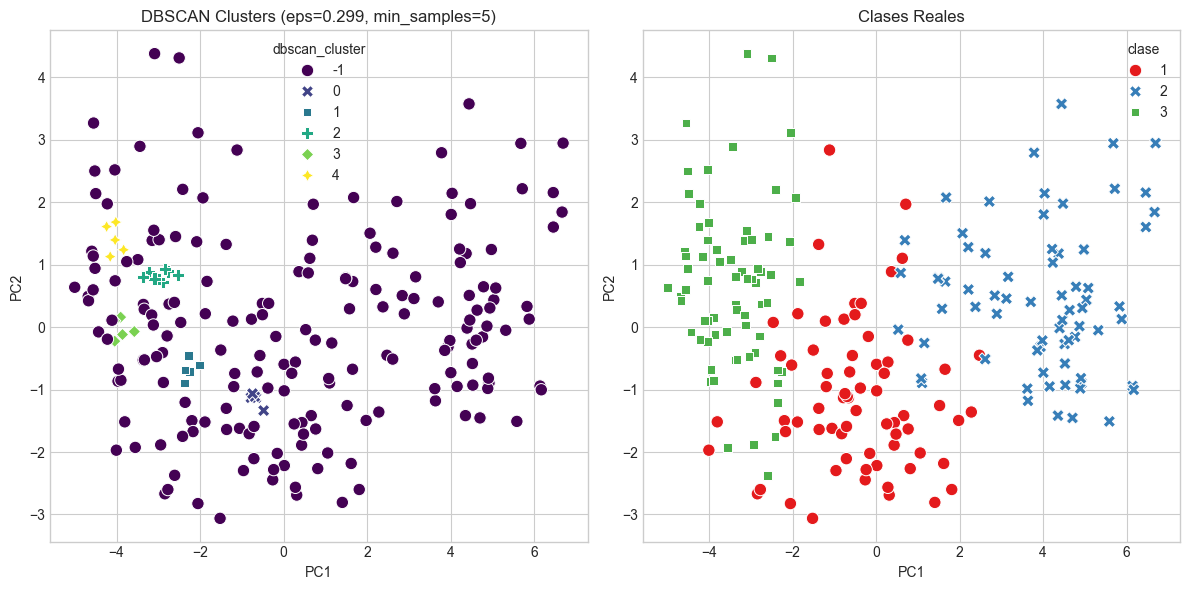


Tabla de Contingencia: DBSCAN vs. Clase
clase            1   2   3
dbscan_cluster            
-1              63  70  49
 0               5   0   0
 1               2   0   3
 2               0   0   8
 3               0   0   5
 4               0   0   5


In [9]:
df_with_pca = pd.concat([df, pca_df], axis=1)

# ------------------ comparamos K-Means con 'clase' -------------------
n_clusters_kmeans = 3
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=495752, n_init=10)
df_with_pca['kmeans_cluster'] = kmeans.fit_predict(df.drop(columns='clase'))

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_with_pca, x='PC1', y='PC2', hue='kmeans_cluster', palette='viridis', style='kmeans_cluster', s=80)
plt.title(f"K-Means Clusters (k={n_clusters_kmeans})")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_with_pca, x='PC1', y='PC2', hue='clase', palette='Set1', style='clase', s=80)
plt.title("Clases Reales")
plt.tight_layout()
plt.show()

# tabla de contingencia para K-Means vs. Clase
print("\nTabla de Contingencia: K-Means vs. Clase")
print(pd.crosstab(df_with_pca['kmeans_cluster'], df_with_pca['clase']))

# ------------------ comparamos Clustering Jerárquico con 'clase' -------------------
n_clusters_hierarchical = 2
hierarchical = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, linkage='average')
df_with_pca['hierarchical_cluster'] = hierarchical.fit_predict(df.drop(columns='clase'))

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_with_pca, x='PC1', y='PC2', hue='hierarchical_cluster', palette='viridis', style='hierarchical_cluster', s=80)
plt.title(f"Clustering Jerárquico (k={n_clusters_hierarchical}, average)")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_with_pca, x='PC1', y='PC2', hue='clase', palette='Set1', style='clase', s=80)
plt.title("Clases Reales")
plt.tight_layout()
plt.show()

# tabla de contingencia para Clustering Jerárquico vs. Clase
print("\nTabla de Contingencia: Clustering Jerárquico vs. Clase")
print(pd.crosstab(df_with_pca['hierarchical_cluster'], df_with_pca['clase']))

# ------------------  comparamos DBSCAN con 'clase' -------------------
eps_dbscan = 0.299
min_samples_dbscan = 5
dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
df_with_pca['dbscan_cluster'] = dbscan.fit_predict(X_pca)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_with_pca, x='PC1', y='PC2', hue='dbscan_cluster', palette='viridis', style='dbscan_cluster', s=80)
plt.title(f"DBSCAN Clusters (eps={eps_dbscan}, min_samples={min_samples_dbscan})")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_with_pca, x='PC1', y='PC2', hue='clase', palette='Set1', style='clase', s=80)
plt.title("Clases Reales")
plt.tight_layout()
plt.show()

# tabla de contingencia para DBSCAN vs. Clase (sin contar el ruido)
print("\nTabla de Contingencia: DBSCAN vs. Clase")
print(pd.crosstab(df_with_pca['dbscan_cluster'], df_with_pca['clase']))

Tras obtener estos resultados, ahora analizaremos la relación entre clusters y las clases reales.

**K-Means**: En el gráfico, podemos observar que los clusters generados parecen solaparse con las distribuciones de las clases reales. Por ejemplo, el cluster 0 parece contener principalmente la clase 2, el cluster 1 se asocia fuertemente con la clase 1 y el cluster 2 se alinea bastante bien con la clase 3.

Si analizamos la tabla de contingencia vemos que:

- El cluster 0 contiene principalmente la clase 2 (60) con muy pocos de la clase 1 (1)

- El cluster 1 tiene una cantidad significativa de puntos de la Clase 1 (60), junto con algunos de la Clase 2 (10) y muy pocos de la Clase 3 (2)

- El cluster 2 se asocia principalmente con la clase 3 (68), con una pequeña contaminación de la clase 1 (9).

En general, logra separar las clases reales hasta cierto punto. Sin embargo, la mezcla en el Cluster 1 sugiere que las clases reales no son perfectamente linealmente separables en las dos primeras componentes principales del PCA.


**Clustering Jerárquico**: Con 2 clusters muestra una división más binaria en comparación con las tres clases reales. El cluster 0 parece abarcar una mezcla de las clases 1 y 3 mientras que el otro cluster (1) se asocia más con la clase 2.

Analizando la tabla de Contingencia:

- El cluster 0 contiene una mezcla considerable de las tres clases reales (69 de la clase 1, 6 de la clase 2 y 70 de la clase 3).

- El cluster 1 se asocia principalmente con la clase 2 (64), con una pequeña presencia de la clase 1 (1) y ninguna de la clase 3.

No se alinea tan bien con las tres clases reales. Si bien identifica un grupo asociado principalmente con la clase 2, el otro cluster mezcla las otras dos clases de manera significativa.


**DBSCAN**: Identifica varios clusters basados en la densidad y una parte importante de los datos se considera ruido. Algunos de los clusters pequeños se correlacionan con subgrupos dentro de las clases reales (por ejemplo, clusters que contienen principalmente la Clase 1 o la Clase 3). Sin embargo, el ruido contiene puntos de las tres clases reales, lo que indica que muchos puntos no se encuentran en áreas de alta densidad definidas por los parámetros de **DBSCAN**.

Analizando la tabla de contingencia:

- Cluster -1 (Ruido): Este es el grupo más grande identificado por DBSCAN. Contiene una cantidad considerable de puntos de cada una de las clases reales: 63 de la Clase 1, 70 de la Clase 2 y 49 de la Clase 3. Esto sugiere que muchos puntos de las tres clases no se consideraron lo suficientemente densos como para formar clusters bajo los parámetros definidos para DBSCAN.

- Cluster 0: Este pequeño cluster contiene exclusivamente puntos de la Clase 1 (5).

- Cluster 1: Este cluster también es pequeño y contiene puntos de la Clase 1 (2) y la Clase 3 (3).

- Cluster 2: Este cluster contiene únicamente puntos de la Clase 3 (8).

- Cluster 3: Al igual que el cluster 2, este también contiene solo puntos de la Clase 3 (5).

- Cluster 4: Este cluster también está compuesto únicamente por puntos de la Clase 3 (5).

Ha identificado algunos clusters que son relativamente "puros" en términos de las clases reales (como el cluster 0 con la Clase 1 y los clusters 2, 3 y 4 con la Clase 3). Sin embargo, la gran cantidad de ruido que contiene puntos de las tres clases indica que la estructura de densidad identificada no se alinea bien con la separación de las clases reales.

En conclusión, **K-Means** parece ser el algoritmo que mejor se alinea con las tres clases reales en este caso, el **Clustering Jerárquico** no refleja bien la separación en tres clases y **DBSCAN** identifica estructuras de densidad que no se corresponden directamente con las tres clases originales, marcando muchos puntos de todas las clases como ruido.


Finalmente, interpretaremos los clusters formados utilizando representaciones gráficas como boxplots, lo que nos permitirá examinar las características que definen cada grupo y comprender mejor su significado desde el punto de vista de las variables originales del conjunto de datos.

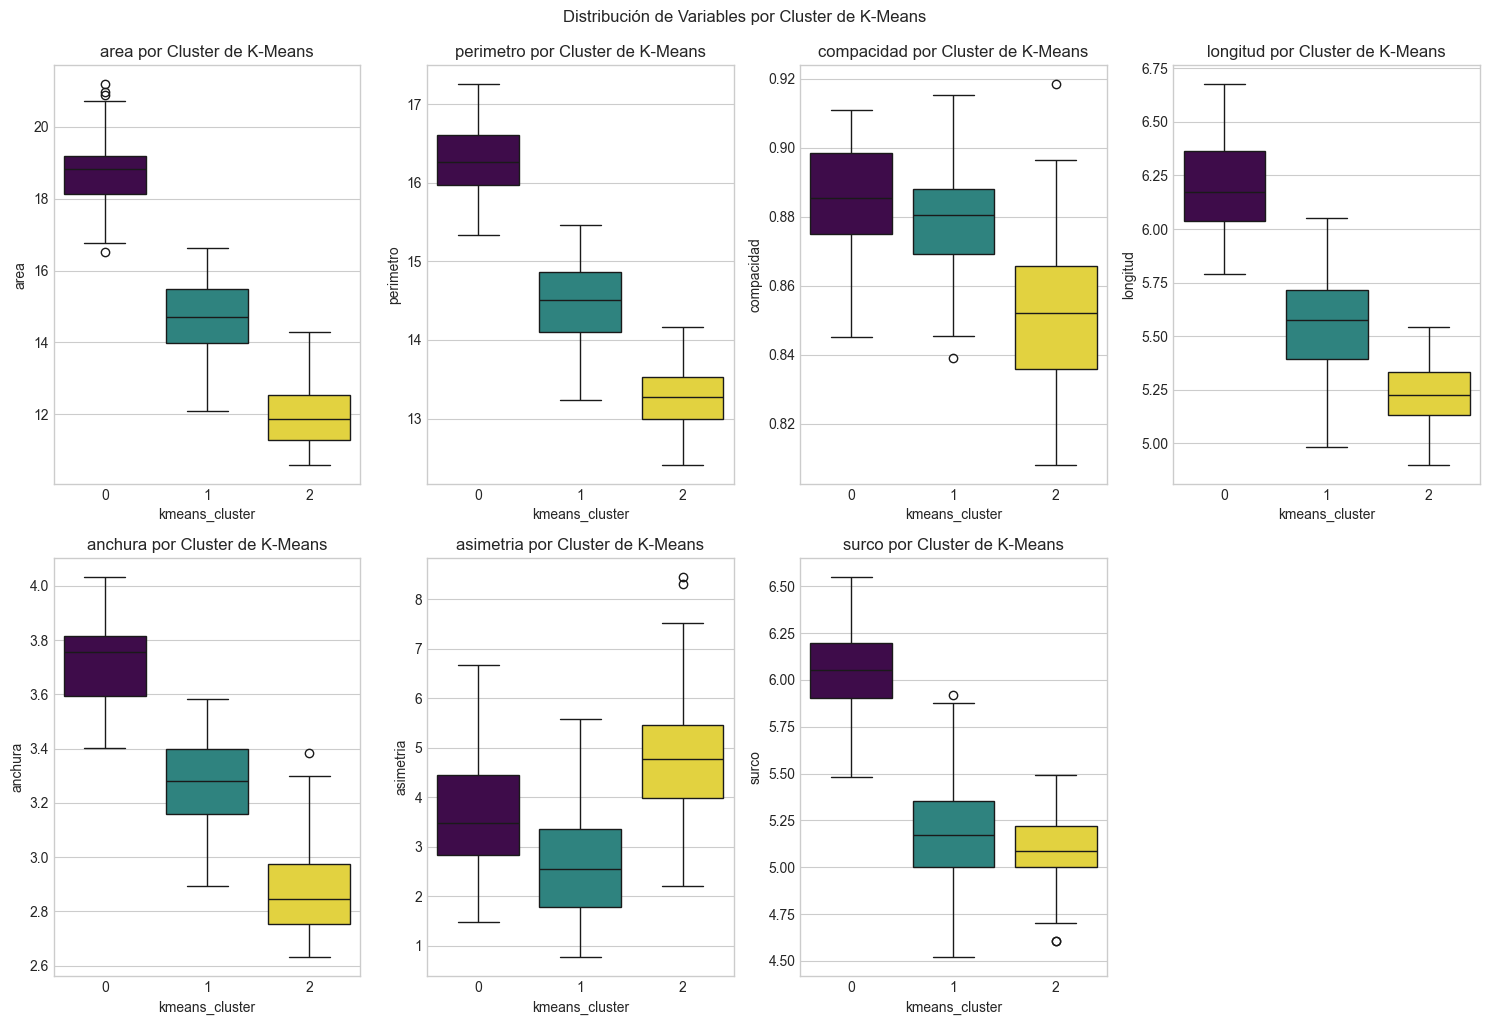

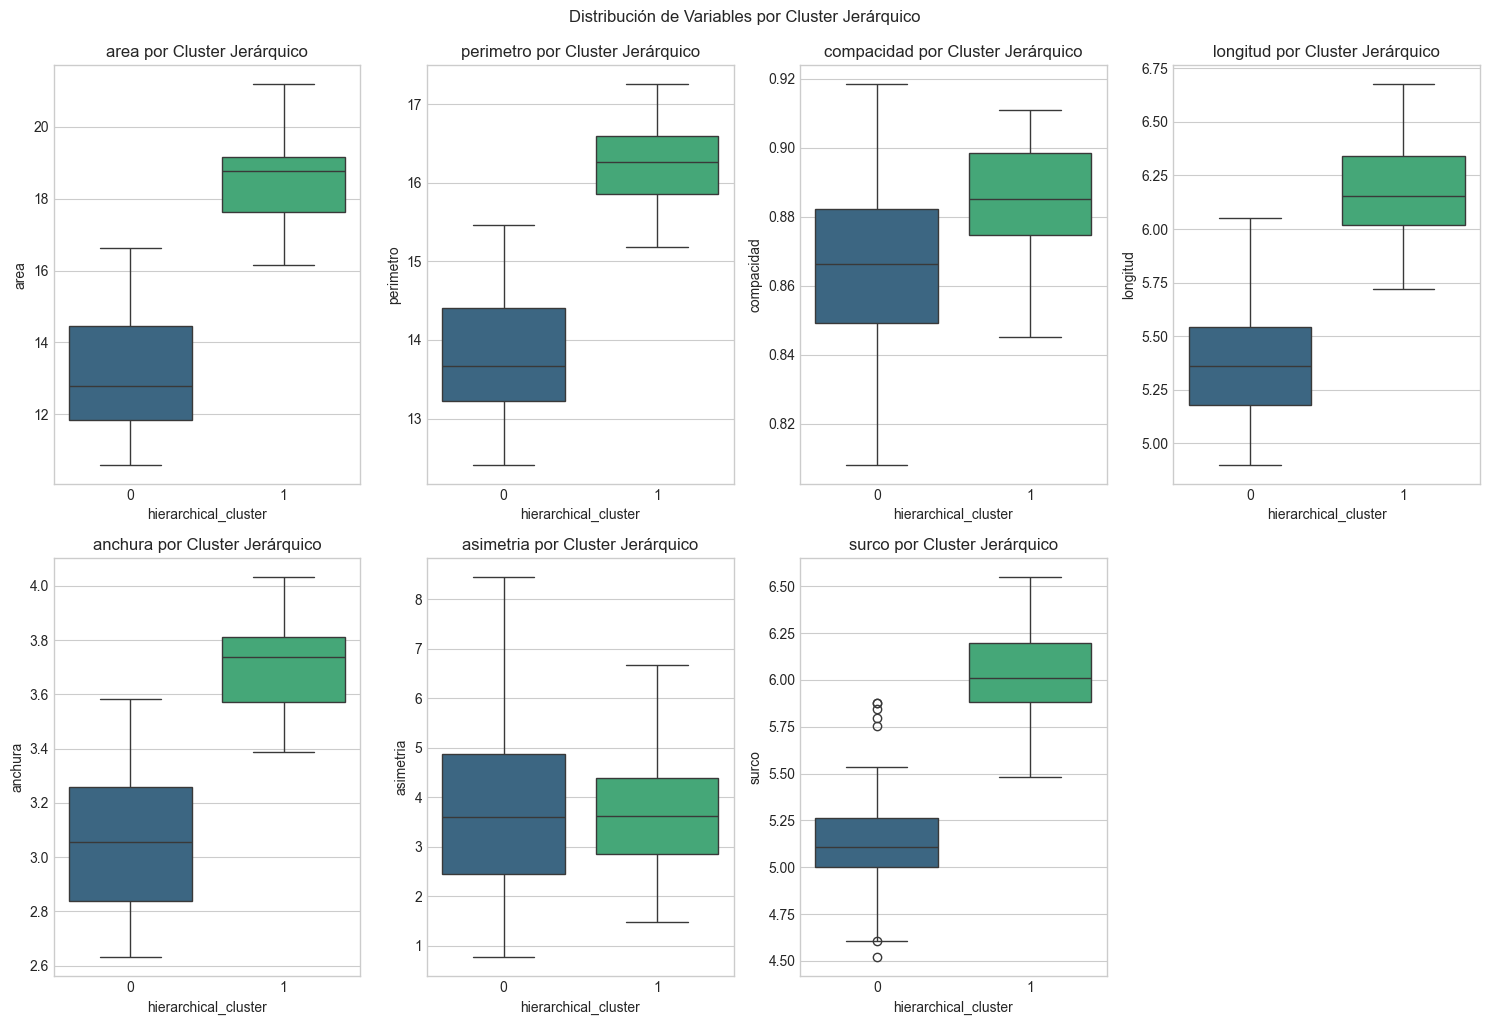

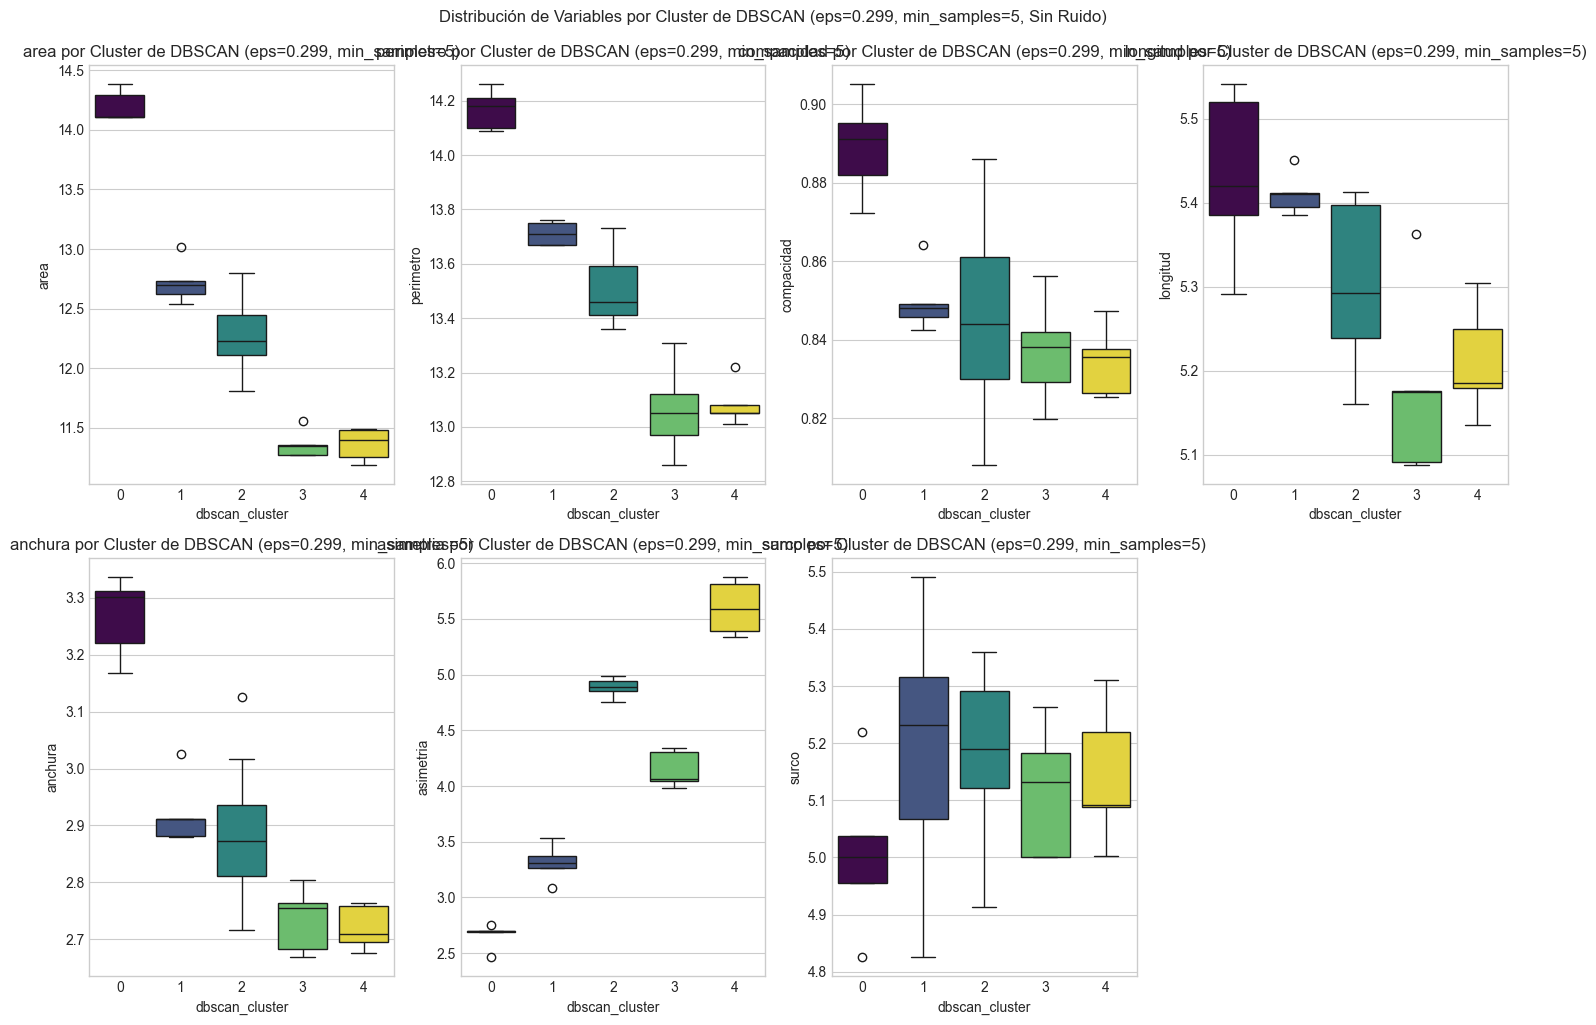

In [10]:
# variables originales (excluyendo 'clase')
original_variables = df.columns[:-1]

# ------------------ Boxplots para K-Means -------------------
df_kmeans_boxplot = df.copy()
kmeans = KMeans(n_clusters=3, random_state=495752, n_init=10)
df_kmeans_boxplot['kmeans_cluster'] = kmeans.fit_predict(df.drop(columns='clase'))

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 10))
for i, var in enumerate(original_variables):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x='kmeans_cluster', y=var, data=df_kmeans_boxplot, palette='viridis', hue='kmeans_cluster', legend=False)
    plt.title(f'{var} por Cluster de K-Means')
plt.tight_layout()
plt.suptitle('Distribución de Variables por Cluster de K-Means', y=1.02)
plt.show()

# ------------------ Boxplots para Clustering Jerárquico -------------------
df_hierarchical_boxplot = df.copy()
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='average')
df_hierarchical_boxplot['hierarchical_cluster'] = hierarchical.fit_predict(df.drop(columns='clase'))

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 10))
for i, var in enumerate(original_variables):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x='hierarchical_cluster', y=var, data=df_hierarchical_boxplot, palette='viridis', hue='hierarchical_cluster', legend=False)
    plt.title(f'{var} por Cluster Jerárquico')
plt.tight_layout()
plt.suptitle('Distribución de Variables por Cluster Jerárquico', y=1.02)
plt.show()

# ------------------ Boxplots para DBSCAN (usando los resultados existentes) -------------------
df_dbscan_boxplot = df.copy()
# aseguramos que las etiquetas de 'dbscan_cluster' estén presentes, usamos los resultados obtenidos anteriormente
if 'dbscan_cluster' in df_with_pca.columns:
    df_dbscan_boxplot['dbscan_cluster'] = df_with_pca['dbscan_cluster']
    df_dbscan_no_noise_boxplot = df_dbscan_boxplot[df_dbscan_boxplot['dbscan_cluster'] != -1]

    # solo graficamos si hay clusters distintos del ruido -1
    if df_dbscan_no_noise_boxplot['dbscan_cluster'].nunique() > 0:
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(15, 10))
        for i, var in enumerate(original_variables):
            plt.subplot(2, 4, i + 1)
            sns.boxplot(x='dbscan_cluster', y=var, data=df_dbscan_no_noise_boxplot, palette='viridis', hue='dbscan_cluster', legend=False)
            plt.title(f'{var} por Cluster de DBSCAN (eps=0.299, min_samples=5)')
        plt.tight_layout()
        plt.suptitle('Distribución de Variables por Cluster de DBSCAN (eps=0.299, min_samples=5, Sin Ruido)', y=1.02)
        plt.show()
    else:
        print("No se encontraron clusters distintos del ruido con los parámetros actuales de DBSCAN.")
else:
    print("La columna 'dbscan_cluster' no se encontró en df_with_pca.")

Ahora vamos a analizar los boxplots de cada técnica.

**K-Means**

- Cluster 0: Tiende a tener semillas con valores más grandes en área, perímetro, compacidad, longitud, anchura y surco, asimetría intermedia.

- Cluster 1: Muestra semillas con un área, perímetro, compacidad, longitud, anchura y surco generalmente mayores que el Cluster 2, su asimetría es menor.

- Cluster 2: Representa semillas con valores generalmente bajos.


**Clustering Jerárquico**

- Cluster 0: Contiene semillas con una gama más amplia de valores para todas las variables, incluyendo áreas más pequeñas, perímetros más pequeños, menor compacidad, menor longitud, menor anchura, menor asimetría y menor surco en general.

- Cluster 1: Muestra semillas con valores generalmente más altos para el área, perímetro, compacidad, longitud, anchura, asimetría y surco en comparación con el Cluster 0.


**DBSCAN (Sin Ruido)**: Los clusters se forman por densidad.  Los valores dentro de un cluster indican las características compartidas por las semillas en esas regiones de alta densidad.

- Cluster 0: Parece tener semillas con un área, perímetro, longitud y anchura relativamente grandes, una compacidad alta, una asimetría baja y un surco intermedio.

- Cluster 1: Muestra semillas con un área, perímetro, longitud y anchura intermedios, una compacidad intermedia y una asimetría y surco bajos.

- Cluster 2: Representa semillas con un área, perímetro, longitud y anchura intermedios a bajos, una compacidad baja y una asimetría y surco intermedios.

- Cluster 3: Contiene semillas con valores bajos para el área, perímetro, longitud y anchura, una compacidad baja, una asimetría alta y un surco bajo.

- Cluster 4: Muestra semillas con los valores más bajos para el área, perímetro, longitud y anchura, una compacidad baja y una asimetría y surco intermedios a bajos.

En resumen, cada técnica ha ofrecido una perspectiva diferente sobre la estructura de los datos de las semillas. 

- **K-Means** proporciona una separación en tres grupos con diferencias notables en el tamaño y la forma de las semillas. 

- **Clustering Jerárquico** ofrece una separación más amplia en dos grupos basados principalmente en el tamaño general de las semillas.

- **DBSCAN** identifica grupos más específicos basados en la densidad, lo que resulta en clusters con combinaciones distintivas de las variables originales.